# Import necessary modules

In [1]:
import numpy as np #computing
import matplotlib.pyplot as plt #plotting
import scipy.optimize as opt #optimization

import pandas as pd #data handling

# Define some initial functions

In [2]:
#calculate center of mass of ROI image as initial estimate for center of bead
def array_cm(array):
    ylen, xlen = array.shape
    xcoords, ycoords = np.meshgrid(range(xlen), range(ylen)) #create the coordinates from origin
    xcm = np.sum(array*xcoords)/np.sum(array)
    ycm = np.sum(array*ycoords)/np.sum(array) #calculate center of mass
    
    return xcm, ycm

#turn the intensities into weights
#make darker spots "weigh" more
#POSSIBLE SOURCE OF SYSTEMATIC ERROR
def conv_to_weights(array):
    adj = (array-array.min())/(array.max()-array.min()) #min-max scale
    
    #apply a nonlinearity
    return 2/(1+np.exp(3*adj)) 
    #return 1/(1+10*adj)
    #return (1-adj)**2

#plot the image with the fitted circle on top
def plot_fit(array, best_x, best_y, best_radius): 
    new_array = array.copy()
    new_array[round(best_y), round(best_x)] = 0 #make the center a dark spot
    
    #parameterization of the circle
    times = np.linspace(0,2*np.pi,101)
    horiz = best_radius*np.sin(times)+best_x
    vert = best_radius*np.cos(times)+best_y

    #plot and show
    plt.imshow(new_array, cmap = 'gray', vmin=0, vmax=256, origin='lower')
    plt.plot(horiz,vert)

#input the centers of every fit
#return variance and stiffness
def calc_stiffness(all_x, all_y, all_rad, graph=False):
    x1 = all_x - all_x.mean() #mean subtracted
    y1 = all_y - all_y.mean()
    
    conv = 1.380649*10**-23*300*10**18/269**2*1000 #conversion factor based on literature converted to sq pixels
    var_disp = np.mean(x1**2+y1**2) #variance of displacement in sq pixels
    trap_stiff = conv/var_disp #calculate the stiffness
    
    if graph: #optional to graph the data as well
        fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex = True, figsize = (4,12))

        ax1.plot(x1)
        ax1.set_ylabel('X displacements')

        ax2.plot(y1)
        ax2.set_ylabel('Y displacements')

        ax3.plot(all_rad)
        ax3.set_ylabel('Radius')
        ax3.set_xlabel('Frame number')

        plt.show()    
    
    return var_disp, trap_stiff

In [3]:
#show the calculation of the conversion factor
conv = 1.380649*10**-23*300*10**18/269**2*1000
conv

5.724004643385249e-05

# Generating simulated images 

In [4]:
#creates a wiener process - OUT OF USE
def wiener_process(number, sd=0.01): 
    rands = sd*np.random.randn(number)
    return np.cumsum(rands)

#creates an Ornstein-Uhlenbeck process based on formula from Wikipedia - OUT OF USE
def OU_process(number, k=2e-7, sd=3.16e-4): 
    rands = np.random.randn(number)
    t = np.arange(number)
    exp_k_t = np.exp(-k*t)
    exp_k_s = 1/exp_k_t
    integral_W = np.insert(np.cumsum(exp_k_s*rands),0,0)[:-1]
    return sd * exp_k_t * integral_W

#returns normal random samples for a given stiffness and degrees of motion
def gauss_OU_approx(number, expected_stiffness, ndim=2):
    conv = 1.380649*10**-23*300*10**18/269**2*1000 #conversion factor
    var_each = conv/expected_stiffness/ndim
    rands = np.random.randn(number, ndim)
    return np.sqrt(var_each)*rands

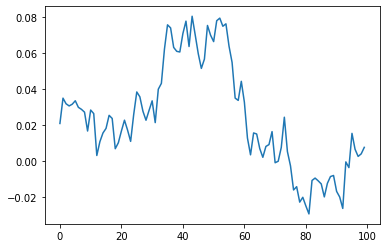

In [5]:
#show an example of the wiener process
plt.plot(wiener_process(100))
plt.show()

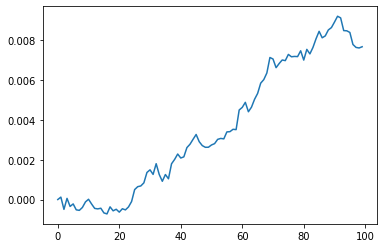

In [6]:
#show an example of the OU process
plt.plot(OU_process(100))
plt.show()

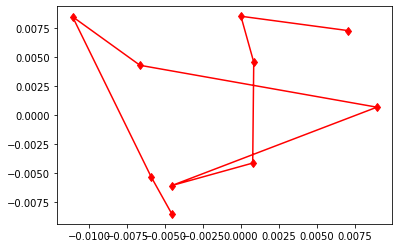

In [7]:
#plot movement of the center of the bead for some iterations 
test = gauss_OU_approx(10, 0.5)
plt.plot(test[:,0], test[:,1], "rd-")
plt.show()

In [5]:
#generate a perfect gaussian ring
#inputs: grid size, center, radius, other parameters, noise in the image or not
#outputs: gaussian ring on a grid
def gen_gaussian_ring(img_size, centerx, centery, radius, sigma=2, amp=-20, background=175, noise=0):
    values = np.arange(0, img_size)
    x_vals, y_vals = np.meshgrid(values, values) #create coordinate system
    rands = noise*np.random.randn(img_size, img_size) #some random noise
    dists = np.sqrt((x_vals-centerx)**2+(y_vals-centery)**2)-radius #calculate distance
    brightnesses = amp*np.exp(-dists**2/sigma)+background+rands #calculate and scale the gaussian distribution
    
    return brightnesses

#create a series of gaussian images
#inputs: number of images, other parameters
def gen_gaussian_series(num_frames, img_size=40, centerx=20, centery=20, radius=9, sigma=2, amp=-20, background=175, noise=0, expected_stiffness=0.5, perfect=True):
    #set up coordinates as 3-D array (time and spatial)
    values = np.arange(0, img_size)
    x_vals, y_vals = np.meshgrid(values, values)
    
    #repeat the grid time on the first axis
    x_vals, y_vals = np.tile(x_vals, (num_frames,1,1)), np.tile(y_vals, (num_frames,1,1)) 
    
    #add movement based on the normal approx of the ornstein-uhlenbeck process
    bead_disps = gauss_OU_approx(num_frames, expected_stiffness)
    center_movex = bead_disps[:,1].reshape((-1,1,1))
    center_movey = bead_disps[:,0].reshape((-1,1,1))
    new_center_x, new_center_y = centerx+center_movex, centery+center_movey #move the centers
    
    #add camera noise
    rands = noise*np.random.randn(num_frames, img_size, img_size)
    
    #turn into images
    dists = np.sqrt((x_vals-new_center_x)**2+(y_vals-new_center_y)**2)-radius #calculate distance
    
    #make a change if we don't want a perfect Gaussian
    if not perfect:
        sigma *= 1+9*(dists<0) #drops off more slowly within ring
    
    brightnesses = amp*np.exp(-dists**2/sigma)+background+rands #calculate and scale the gaussian distribution
    
    #POSSIBLE SOURCE OF ERROR - rounding to integer values
    return brightnesses.astype('uint8'), center_movex, center_movey

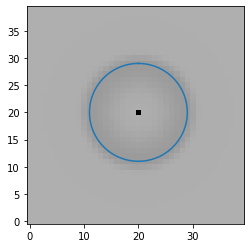

In [25]:
#plot a sample bead
sim_bead, cy, cx = gen_gaussian_series(1, img_size=40, centerx=20, centery=20, radius=9, perfect=False) #simulate one bead
plot_fit(sim_bead[0], 20, 20, 9) #plot the image and ideal fit

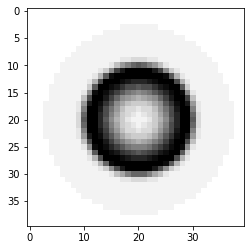

In [26]:
plt.imshow(sim_bead[0], cmap="gray")
plt.show()

In [19]:
file = "../Bead movies 06_16_22/AVI numbers/4.0W_full_nums.npy"
nums = np.load(file)

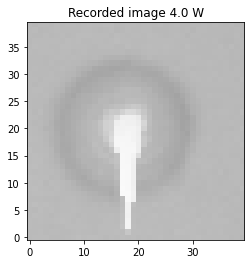

In [22]:
plt.imshow(nums[225:265,255:295,10], vmax=255, vmin=0, origin="lower", cmap="gray")
plt.title("Recorded image 4.0 W")
plt.show()

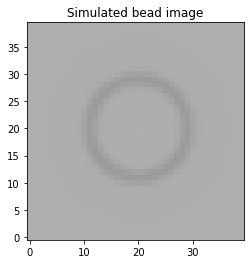

In [9]:
plt.imshow(sim_bead[0], cmap="gray", vmin=0, vmax=255, origin="lower")
plt.title("Simulated bead image")
plt.show()

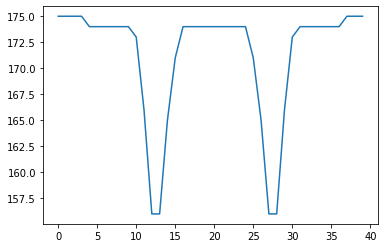

In [10]:
#plot a non-central cross section
plt.plot(sim_bead[0,25,:])
plt.show()

## Hermitian ring

Might be unnecessary, but another example of a bead that looks like what we want to fit.

In [11]:
#NOT IN USE YET
#create a ring where brightness is power law distribution of distance from edge
def hermite_2(x_vals):
    y_vals = (x_vals)**2+0.3
    return y_vals

#NOT IN USE YET
def gen_hermite_ring(img_size, centerx, centery, radius, amp=20, rate=-0.3, width=1.5, background=175):
    values = np.arange(0, img_size)
    x_vals, y_vals = np.meshgrid(values, values) #create coordinate system
    dists = np.sqrt((x_vals-centerx)**2+(y_vals-centery)**2) #calculate distance
    brightnesses = background - amp*hermite_2(dists/width)*np.exp(-dists**2) #calculate and scale the power law    
    
    return brightnesses

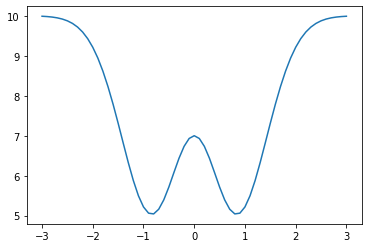

In [12]:
#plot an example of the hermite polynomial
x = np.arange(-3,3.1,0.1)
plt.plot(x, 10-10*hermite_2(x)*np.exp(-x**2))
plt.show()

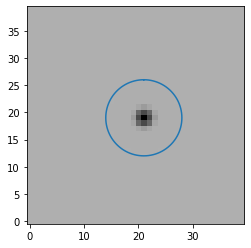

In [13]:
#sample hermite bead - not high priority right now
sim_hermite = gen_hermite_ring(img_size=40, centerx=21, centery=19, radius=7, width = .5, amp = 64)
plot_fit(sim_hermite, 21, 19, 7) #plot the image and ideal fit

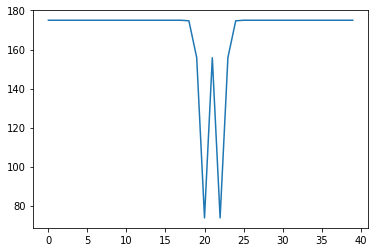

In [14]:
#plot a cross section of the hermite bead
plt.plot(sim_hermite[19,:])
plt.show()

# Fitting functions 

In [107]:
#Gaussian fit like the LabVIEW code
#inputs: values to be fit, intensities, all x coords, all y coords, weights
#output: mean squared error
def fit_gauss(vals, img_array, weights=None): #fits the gaussian intensity profile to the pixels
    img_array = img_array.astype('float')
    
    #get the weights for the pixels
    if weights is None:
        weights = np.ones_like(img_array)
    weights = weights/np.sum(weights)
    
    #unpack values to be fit
    centerx, centery, radius, sigma, amp, back = vals
    
    #calculate the error
    this_gauss = gen_gaussian_ring(img_array.shape[0], centerx, centery, radius, sigma, amp, back)
    diff = img_array - this_gauss
    
    return np.sum(diff**2*weights)

#use the previous function to optimize a Gaussian fit 
def gauss_disp(img_array, init = None):
    img_array = img_array.astype('float')
    
    #initial estimate
    if init:
        xcm, ycm = init
    else:
        dark_weights = conv_to_weights(img_array)
        xcm, ycm = array_cm(dark_weights)
    
    #optimize the fit, starting with estimated values
    result = opt.minimize(fit_gauss, [xcm, ycm, 9, 3, -20, 170], args=(img_array), tol=1e-8)
    best_x, best_y, best_radius, best_sig, best_amp, best_back = result.x
    
    return best_x, best_y, best_radius

In [28]:
#CAF fit, new method from literature

#takes current array and circle, calculates the delta values
def iter_circle(weights, xc, yc, radius, width):
    grid_size = weights.shape[0]
    
    #get points used in the calculation
    num_points = int(2*np.pi*radius)
    angles = np.arange(num_points).reshape((1,-1))/radius #length = num_points
    bottom = np.max((0, radius-width))
    radii = np.arange(bottom, radius+width+1).reshape((-1,1)) #length <= 2*width+1
    
    #turn points into weights
    #matrices with shape 2*width+1 by num_points
    x_pixels = (xc + radii*np.cos(angles)+0.5).astype('int16')
    x_pixels[x_pixels<0]=0
    x_pixels[x_pixels>grid_size-1]=grid_size-1 #set boundaries
    
    y_pixels = (yc - radii*np.sin(angles)+0.5).astype('int16')
    y_pixels[y_pixels<0]=0
    y_pixels[y_pixels>grid_size-1]=grid_size-1
    
    #fancy indexing to find the brightnesses
    intensities = weights[y_pixels, x_pixels]
    
    #calculate force
    forces = np.sum(intensities*(radii-radius), axis=0)/np.sum(intensities, axis=0)
    forces[np.isnan(forces)] = 0
    
    #calculate movement
    dx = np.sum(forces*np.cos(angles))/num_points
    dy = np.sum(forces*-np.sin(angles))/num_points
    dr = np.sum(forces)/num_points
    
    return dx, dy, dr

#use the CAF algorithm to fit an image
#inputs: array of pixels, difference between circle and annulus radii
#minimum convergence rate and maximum iteration count before stopping the algorithm
#output: final fit values, end convergence rate, end number of iterations
def CAF_fit(array, init = None, radius=10, width=5, min_converge = 1e-4, max_iter = 1000):    
    weights = conv_to_weights(array.astype('float')) #convert to weights
    
    #initial center
    if init:
        xc, yc = init
    else:
        xc, yc = array_cm(weights)
    
    #set up other values
    step_num = 0
    converge_rate = min_converge
    tracking = np.zeros([max_iter+1, 3])
    tracking[0,:] = xc, yc, radius
    
    #iterate CAF_fit algorithm until the fit converges
    while converge_rate >= min_converge and step_num < max_iter:
        dx, dy, dr = iter_circle(weights, xc, yc, radius, width) #calculate step
        xc, yc, radius = xc+dx, yc+dy, radius+dr #take step
        converge_rate = dx**2 + dy**2 + dr**2 #calculate rate
        step_num += 1 #track iteration number
        tracking[step_num, : ] = xc, yc, radius #track all the values  
        #print(f'{xc:.2f}, {yc:.2f}, {radius:2f}')
        
    tracking = tracking[:step_num, :] #truncate
    
    return xc, yc, radius, converge_rate, step_num

# Test the fits using simulated images - LOOK AT THIS SECTION

Expected variance given a trap stiffness around 0.5 pN/nm is 1e-4.

In [101]:
#function that simulates trials and returns stiffness
def test_algorithm(fit_alg, num_frames = 100, expected_stiffness = False, noise = False, perfect=False, graph = False):
    #generate video and set up variables
    sim_video, center_movex, center_movey = gen_gaussian_series(num_frames = num_frames, img_size = 40, centerx = 20, centery = 20, sigma=2, noise=noise, expected_stiffness=expected_stiffness, perfect=perfect)
    all_x, all_y, all_rad = np.zeros((3,num_frames))
    best_x, best_y = (20,20)
    
    #based on algorithm input choice
    if fit_alg == "Gaussian":
        for ct in range(num_frames):
            best_x, best_y, best_rad = gauss_disp(sim_video[ct], init=None)
            all_x[ct] = best_x
            all_y[ct] = best_y
            all_rad[ct] = best_rad
    
    elif fit_alg == "CAF":
        for ct in range(num_frames):
            best_x, best_y, best_rad, _, _ = CAF_fit(sim_video[ct], init=(best_x, best_y))
            all_x[ct] = best_x
            all_y[ct] = best_y
            all_rad[ct] = best_rad
    
    else:
        raise ValueError("Not a valid fitting algorithm")

    var, stiffness = calc_stiffness(all_x, all_y, all_rad, graph=False)
    return var, stiffness, center_movex, center_movey, all_x, all_y, all_rad, sim_video

In [108]:
#the stiffness we should get from this simulation
k=0.5

#either "CAF" or "Gaussian"
fit_type = "Gaussian"

var, stiffness, center_movex, center_movey, all_x, all_y, all_rad, video = test_algorithm(fit_type, 
                                                                          num_frames=100, 
                                                                          expected_stiffness=k, 
                                                                          noise=0, 
                                                                          perfect = True)

In [42]:
#calculate the total variance of the process
np.var(center_movex)+np.var(center_movey)

9.38419698564162e-05

In [109]:
#calculate the stiffness based on fitting
stiffness

0.24727875645270028

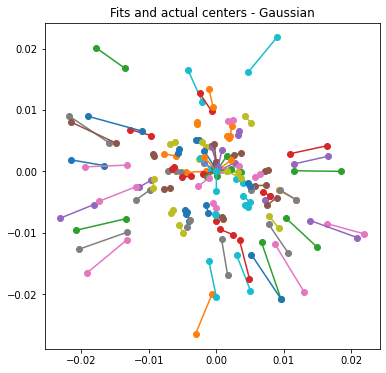

In [45]:
#combine the data
combx = np.vstack([center_movex.flatten(), all_x-20])
comby = np.vstack([center_movey.flatten(),  all_y-20])

#plot actual movements and fitted movements together
#color corresponds to two points - fit and actual
plt.figure(figsize=(6,6))
plt.plot(combx, comby, "o-")
plt.title("Fits and actual centers - " + fit_type)
plt.show()

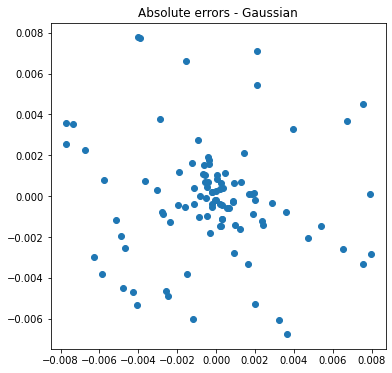

In [110]:
#plot difference between fit and actual centers
plt.figure(figsize=(6,6))
plt.plot(all_x-20-center_movex.flatten(), all_y-20-center_movey.flatten(), "o")
plt.title("Absolute errors - " + fit_type)
plt.show()

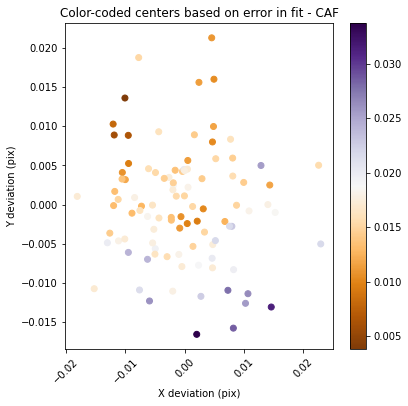

In [58]:
#color code based on magnitude of residual
resid_mag = np.sqrt((center_movex.flatten()-all_x+20)**2 + (center_movey.flatten()-all_y+20)**2)

#make plot
plt.figure(figsize=(6,6))
plt.scatter(center_movex.flatten(), center_movey.flatten(), c=resid_mag, cmap="PuOr")
plt.xlabel("X deviation (pix)")
plt.xticks(rotation=45)
plt.ylabel("Y deviation (pix)")
plt.title("Color-coded centers based on error in fit - " + fit_type)
plt.colorbar()
plt.show()

Actual Center: (-0.010, 0.014)
Fitted Center: (-0.010, 0.010)


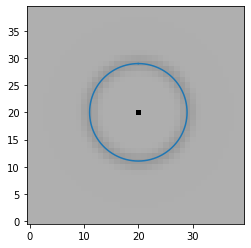

In [61]:
#plot the fit with the least error
idx = resid_mag.argmin()
least_var_img = video[idx]
plot_fit(least_var_img, all_x[idx], all_y[idx], all_rad[idx])
print(f"Actual Center: ({center_movex.flatten()[idx]:.3f}, {center_movey.flatten()[idx]:.3f})")
print(f"Fitted Center: ({all_x[idx]-20:.3f}, {all_y[idx]-20:.3f})")

Actual Center: (0.002, -0.017)
Fitted Center: (0.017, -0.047)


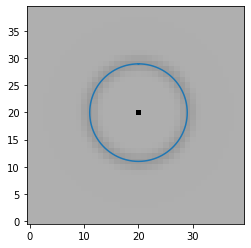

In [60]:
#plot the fit with the most error
idx = resid_mag.argmax()
most_var_img = video[idx]
plot_fit(most_var_img, all_x[idx], all_y[idx], all_rad[idx])
print(f"Actual Center: ({center_movex.flatten()[idx]:.3f}, {center_movey.flatten()[idx]:.3f})")
print(f"Fitted Center: ({all_x[idx]-20:.3f}, {all_y[idx]-20:.3f})")

When there's no noise in the image, both algorithms appear to have a systematic error. CAF seems to fit the x coordinate improperly ("residual" is always positive). Gaussian seems to leave "residuals" near the line y=x.

With the addition of noise, the systematic error seems to disappear and become more random. However, unsurprisingly, the stiffness also decreases as the algorithms end up with more variance.

## A combination of variables

In [26]:
"""
#test a large combination of variables to see how noise and movement affect fitting 
noises = (0,0.25,0.5,1,2,4)
moves = (0, 0.0025, 0.005, 0.01, 0.02, 0.04)
values = np.zeros([len(noises), len(moves)])

#for a set of noise values and movement values
for i, n in enumerate(noises):
    for j, m in enumerate(moves):
        var, stiffness, center_movex, center_movey = test_algorithm("Gaussian", noise=n, movement=m)
        print(f'Noise = {n}, Movement = {m}, stiffness = {stiff:.4f}')
        values[j,i] = stiff.round(4)

#output the data into a file
#df = pd.DataFrame(values)
#df.to_excel("data.xlsx")
"""

'\n#test a large combination of variables to see how noise and movement affect fitting \nnoises = (0,0.25,0.5,1,2,4)\nmoves = (0, 0.0025, 0.005, 0.01, 0.02, 0.04)\nvalues = np.zeros([len(noises), len(moves)])\n\n#for a set of noise values and movement values\nfor i, n in enumerate(noises):\n    for j, m in enumerate(moves):\n        var, stiffness, center_movex, center_movey = test_algorithm("Gaussian", noise=n, movement=m)\n        print(f\'Noise = {n}, Movement = {m}, stiffness = {stiff:.4f}\')\n        values[j,i] = stiff.round(4)\n\n#output the data into a file\n#df = pd.DataFrame(values)\n#df.to_excel("data.xlsx")\n'